In [0]:
#@title Installs & imports
!pip install -q --upgrade tensorflow==2.1
!pip install -q --upgrade tf-quant-finance

import numpy as np
import tensorflow.compat.v2 as tf
import tf_quant_finance as tff

from tf_quant_finance.rates import forwards

In [0]:
#@title Datetime array functions

day = np.timedelta64(1, 'D')
month = np.timedelta64(1, 'M')
year = np.timedelta64(1, 'Y')
daydtype = '<m8[D]'

def year_fraction(dates, ref_date):
  return (dates - ref_date).astype(np.float64) / 360.

def radd(dt64, td):
  if td.dtype == daydtype:
    return dt64 + td
  m = dt64.astype('<M8[M]')
  return m + td + (dt64 - m)

def rsub(dt64, td):
  if td.dtype == daydtype:
    return dt64 - td
  m = dt64.astype('<M8[M]')
  return m - td + (dt64 - m)

#def random_date_between(min_dates, max_dates, size=None):
#  dt = max_dates - min_dates
#  if size is None:
#    rndfracs = np.random.rand(*(dt.shape))
#  else:
#    rndfracs = np.random.rand(size)
#  return min_dates + dt * rndfracs


## Hull White future yield curves.

For the single factor Hull white model, the conditional forward bond prices are of the [affine form](https://en.wikipedia.org/wiki/Hull%E2%80%93White_model#Bond_pricing_using_the_Hull%E2%80%93White_model):

$$P(S, T) = A(S, T) e^{-B(S,T) r(S)}$$

where

$$B(S, T) = \frac{1}{\alpha} \left(1 - e^{-\alpha (T-S) } \right)$$

and

$$\begin{eqnarray}
\ln A(S, T) &=& \ln \frac{P(0, T)}{P(0, S)} + B(S, T) f(0, S) - \frac{\sigma^2}{4\alpha^3}\left[1-e^{-\alpha (T-S)}\right]^2 (1-e^{-2\alpha S}) \\
&=& \ln \frac{P(0, T)}{P(0, S)} + B(S, T) f(0, S) - \frac{\sigma^2}{4\alpha}B(S,T)^2 (1-e^{-2\alpha S})
\end{eqnarray}
$$

and
$$f(0, S) = -\frac{\partial}{\partial S} \ln P(0, S)$$

Assuming we are given the pair $(S, r(S))$, we can use the above to compute the discount factors as "observed" at time $S$. The set of future times will be given to us and the $r$ at those times will be computed by sampling (see next section.).

## Implementation details

Doing everything in a vectorized manner leads to a bestiary of shapes. The following gives a guide to the process.

### Indices

There are a few different indices to distinguish. The conventions are as follows

  1. Scenarios: Greek indices: $\mu, \nu$ etc. Take values between $1$ and $N_S$ the number of scenarios.
  2. Currencies: There are many currencies and or basis curves for those currencies to consider. Strictly speaking, we will consider a "currency" to be equivalent to a single HW model. The index for this will be lower case roman from the earlier part of the alphabet e.g. $a, b, c$ etc. These will take values between $1$ and $N_c$ the number of currencies.
  3. Calculation dates: These are a sequence of dates starting from today. For each calculation date, we need to pretend that we are on that date and then age the portfolio and price. The index for calculation dates will be $i, j, k$ etc. Take values between $1$ and $M_c$ the number of calculation dates.
  4. Evaluation dates: These are the dates at which we will want to evaluate the discount factors. In practice these will be the dates from the swap schedules but for the function at hand, these could be any dates. Indexed by $p, q, r$ etc. Take values between $1$ and $N_e$ the number of evaluation dates.

### Input data

1. Short Rate: From the simulation of the Hull-White models we will receive the short rate at each calculation date for each scenario and each currency. Hence the input tensor will be represented as $R_{a \mu i}$ which is the short rate value drawn for scenario $\mu$ for the currency $a$ at calculation date $i$.
2. $CD_i$: The tensor of calculation dates. The i'th calculation date.
3. $MR_a$: The mean reversion strength of the HW model for the $a$'th currency.
4. $\sigma_a$: The volatility of the HW model for the $a$'th currency.
5. $ED_p$: The tensor of evaluation dates. The dates at which the discounts have to be calculated.
6. $A_p$: The currency label for the evaluation dates. Takes values in the set of currencies (i.e. $A_p \in \{1, \cdots, N_c\}$). Hence the joint specification of $(ED_p, A_p)$ means that the p'th element requires us to calculate the discount factor for the currency $A_p$ at time $ED_p$ in every scenario and for every calculation date.
7. Todays Discount and Forward functions. $DFF$. This is a callable that will take two arguments. The first argument will be a set of dates in the future and the second paired argument will be a set of indices, one for each date which will indicate which currencies discount curves we want to invoke. The return will be a tuple. The first will be the log discount to the supplied date for the supplied currency and the second is the instantaneous forward for the supplied date and the currency.

### Output

$DF_{p \mu i}$: the discount factor as seen on the calculation date $CD_i$ to date $ED_p$ for currency $A_p$ in scenario $\mu$. Note that it may happen that $ED_p < CD_i$ in which case, we return some sentinel value (possibly 0).


### Calculation

Main formula

$$
\ln DF_{p \mu i} = \left(\ln A\right)_{p \mu i} - (B * R)_{p \mu i}
$$

Define these "gather" operations:

$$\begin{eqnarray}
MR_{p} &\equiv& MR_{A_p} \\
\sigma_{p} &\equiv& \sigma_{A_p} \\
R_{p \mu i} &\equiv& R_{A_p \mu i}
\end{eqnarray}$$

Then
$$
B_{p \mu i} = \frac{1}{MR_{p}} \left( 1 - \exp^{-MR_p (ED_p - CD_i)}\right)
$$

Note that in fact, $B$ is not a function of index $\mu$ (i.e. scenario). Hence
$$B_{p \mu i} \equiv B_{p i}$$.

Similarly to the $B$ term, the $\ln A$ term doesn't depend on the scenario either so we drop the index $\mu$. We also first need to compute some preliminaries.

$$\begin{eqnarray}
(lnP)_{p} &=& DFF(ED_p, A_p)[0] \\
(lnP')_{p i},\  f_{p i} &=& DFF(CD_i, A_p)[0],\  DFF(CD_i, A_p)[1]
\end{eqnarray}$$

Note that the first equation has no dependence on $i$. Then,

$$
(\ln A)_{pi} = (lnP)_{p} - (lnP')_{pi} + B_{p i} * f_{p i} - \frac{(\sigma_p B_{p i})^2}{4 MR_p} * \left(1 - e^{-2 * MR_p * CD_i}\right)
$$



In [0]:
#@title Define the simulaton parameters

# Random multi-variate correlations and vols
mr_min=0.3 # minimum mean reversion
mr_random=0.05 # scale factor for random mr (+mr_min)
vol_scale=0.25
initial_short_rate    = 0.03
flat_zero_curve_level = 0.03



In [0]:
#@title TF implementation of scenario discount curves.

def log_scenario_zeros_with_times(
    short_rates,
    calc_times,
    eval_times,
    currency_groups,
    current_disc_fwd_fn,
    mean_revs,
    sigmas):
  """Computes forward discount factors.

  Produces P(S, T) i.e. the discount factor as seen at time 'S' the calculation date
  for expiry at time 'T' the evaluation date.

  Time today is 0. The eval times are allowed to be negative but not the calc times

  Args:
    short_rates: The short rates of shape: [N_scenarios, Num_calc_dates, Num_currencies].
    calc_times: The calculation times of shape [Num_calc_dates]
    eval_times: The evaluation dates of shape [Num_eval_dates]
    currency_groups: The currency groups of shape [Num_eval_dates] (i.e. same as eval_dates)
    currency_disc_fwd_fn: A callable as described above. Takes two arguments and return a 2-tuple.
    mean_revs: A tensor of shape [num_currencies] The mean reversions for each HW model.
    sigmas: A tensor of same shape as mean_revs.
  
  Returns: A tensor of shape [N_scenarios, num_calc_dates, num_eval_dates]
  """
  mean_revs_p = tf.gather(mean_revs, currency_groups)

  calc_times = tf.expand_dims(calc_times, axis=-1)  # Prepare for broadcasting with eval_dates.
  ##
  start_times = tf.zeros_like(calc_times)
  #
  eval_times_from_calc_times = eval_times - start_times
  ##
  
  b_exp = mean_revs_p * eval_times_from_calc_times  # shape [N_calc_dates, n_eval_dates]
  b = (1 - tf.exp(-b_exp)) / mean_revs_p
  lnP_p = current_disc_fwd_fn(eval_times, currency_groups)[0]  # shape [n_eval_dates]
  lnP_den, inst_fwd = current_disc_fwd_fn(calc_times, currency_groups)  # output of shapes [n_calc_dates, n_eval_dates]
  sigma_p = tf.gather(sigmas, currency_groups)
  
  lnA = lnP_p + b * inst_fwd - ((sigma_p * b) ** 2) * (1 - tf.exp(-2 * mean_revs_p * calc_times))
 
  short_rates_p = tf.gather(short_rates, currency_groups, axis=-1)
  raw_result = (lnA - b * short_rates_p)
  
  return  raw_result


In [0]:
 #@title Hull White Parameters Generation Functions

from collections import namedtuple

def instant_forward_rate_fn(times):   
    rates = tf.ones(num_currencies,dtype=dtype)*0.03*tf.ones_like(times)
    return rates

def log_flat_discount_fwd_fn(times,currency_groups):
     rates = tf.ones_like(times)*flat_zero_curve_level
     return (-flat_zero_curve_level*times),rates

HullWhiteData = namedtuple('HullWhiteData',
                           ['mean_reversion', 'volatility',
                            'log_discount_fwd_fn'])


def gen_hull_white_params(num_currencies):
  mean_reversion = np.random.rand(num_currencies) * mr_random+mr_min
  volatility     = np.random.rand(num_currencies) * vol_scale
  
  return HullWhiteData(
     mean_reversion=mean_reversion,
     volatility=volatility,
     log_discount_fwd_fn=log_flat_discount_fwd_fn)


# On Graph Calculations

1. Using Hull-White Parameters generated above ('hull_white_params') and the calculation dates ('calc_dates/calc_times') generate a number of paths for the
short rate. The number of paths should be 'num_scenarios'.
2. Price the fixed legs: The fixed leg payments and dates are known ('fixed_leg_payments', 'fixed_leg_dates'). Using the short rates drawn above, and the function: 'log_scenario_discounts_with_times' compute the log discount factors at each date. Compute the pv of each swap at each calculation date and each scenario by multiplying the discounts with the payments and summing across
the payment date index. (a reshape will be required)
3. Price the floating legs: The float leg dates are known ('float_leg_dates/times') and we need to find the float leg fixes. First calculate the discounts as for fixed legs above. Then reshape and call the fwd_fixes function to get the discrete forward fixes. Multiply with the payment multiplier ('float_payment_mults') 


In [0]:
#@title Generate short rates. 
# Calibration for the correlations is random
# Initial T0 discount rate is fixed at 3% for all currencies

def generate_short_rates(initial_short_rates, 
                         num_currencies, 
                         hull_white_params, 
                         times, num_scenarios,
                         dtype):
  
  # We will support multiple risk factors with can be correlatetd
  # To test we will generate a random symetric matrix with a unitary diagonal. 
  a = dtype(hull_white_params.mean_reversion)
  sigma = dtype(hull_white_params.volatility)
  corr_matrix = np.random.normal(size=[num_currencies, num_currencies, num_currencies])
  corr_matrix = np.matmul(corr_matrix, np.transpose(corr_matrix, [0, 2, 1]))
  corr_matrix = np.mean(corr_matrix, 0)
  corr_matrix *= 1 / np.diag(corr_matrix)
  corr_matrix = dtype(corr_matrix)

  # The hull white model needs a function to return the T0 forward rates
  # as we currently have a flat zero curve at 3%, forward will also be 3% at T0. 
  # Generalise this to calc forward rates.   
  
  def instant_forward_rate_fn(times):   
    rates = tf.ones(num_currencies,dtype=dtype)*0.03*tf.ones_like(times)
    return rates
  
  
  # We now have enough information to setup the HW process and return the
  # HW paths. Not this is a one factor HW model ( ToDo - generalise to multi-factor)
  process = tff.models.hull_white.VectorHullWhiteModel(
        dim=num_currencies, # The number of currencies to simulate
        mean_reversion=a,   # Mean reversion param per ccy
        volatility=sigma,   # Vol per ccty
        instant_forward_rate_fn=instant_forward_rate_fn, # Calibrate to T0 curve
        corr_matrix=corr_matrix, # Random correlations for now. 
        dtype=dtype)        # Set precision ( so we can  test performance of 32 vs 64 bit on GPUs) 
 
  times = dtype(times)
  sample_paths = tf.function(process.sample_paths)

  paths = sample_paths(
      times,
      num_samples=num_scenarios,
      initial_state=initial_short_rates,
      seed=42)
  return paths

In [0]:
#@title Run the simulation

dtype = np.float64        # we can switch between np.float64 and np.float32
num_calculation_dates=104 # We'll set weekly timepoints for 2 years = 104 
num_scenarios=10          # Scenarios = 10, just for testing. 
num_currencies=2          # Need at least 2 currencies for this vector model. 

## PREWORK

today = np.datetime64('2020-01-09')
WEEK = day * 7
calculation_tenor = WEEK  # week

# Fixed points on zero curves
zero_curve_dates=np.array([0.00,0.5,1,2,3,4,5,6,7,8,9,10])     

# Calculation dates Monthly for 10y
calc_dates = radd(today, np.arange(0, num_calculation_dates + 1) * calculation_tenor)
calc_times = year_fraction(calc_dates, today)
num_calc_dates = calc_times.size

# Generate the random correlations and set all T0 curves to 3%
hull_white_params = gen_hull_white_params(num_currencies)

### PREWORK END

# This is where the simulation happens
# The short rate tensor is generataed 
# This is then used to calculate discount factors ( and therfore Zero curves)
# for each sceanrio / timepoint
short_rates = generate_short_rates(
     0.03 * tf.ones([num_currencies], dtype=dtype),  # initial short rates
      num_currencies,
      hull_white_params, 
      calc_times,         
      num_scenarios,
      dtype=dtype)

currency_groups = tf.ones(1 , dtype=tf.int32)
current_disc_fwd_fn = hull_white_params.log_discount_fwd_fn
mean_revs = tf.constant(hull_white_params.mean_reversion, dtype=dtype)
sigmas = tf.constant(hull_white_params.volatility, dtype=dtype)

eval_times = tf.constant(zero_curve_dates, dtype=dtype)

log_discounts = log_scenario_zeros_with_times(
      short_rates,
      calc_times,
      eval_times,
      currency_groups,
      current_disc_fwd_fn,
      mean_revs,
      sigmas)


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

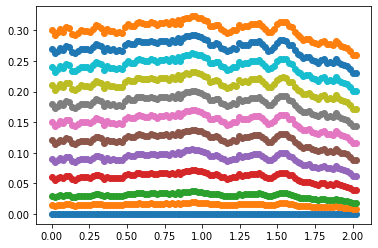

In [25]:
t=np.arange(0,105)/12.0
for i in range(0,12):
    r=-log_discounts[1,:,i]
    plt.plot(calc_times, r,marker='o')

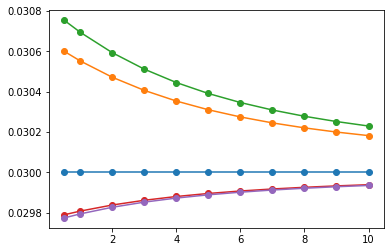

In [26]:
for i in range(0,5):
  r=-log_discounts[2,i,:]/eval_times
  #r=-log_discounts[0,i,:]
  
   # plt.plot(eval_times, -fixed_leg_log_discounts[1,i,0,:])
  plt.plot(eval_times,r,marker='o')

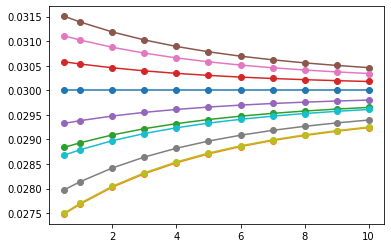

In [27]:
for i in range(0,10):
   r=-log_discounts[1,i,:]/eval_times
 #  r=-log_discounts[i,1,:]
   # plt.plot(eval_times, -fixed_leg_log_discounts[1,i,0,:])
   plt.plot(eval_times[:],r,marker='o')

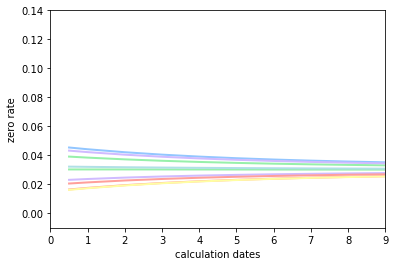

In [28]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(0, 9), ylim=(-0.01, 0.14))
line, = ax.plot([], [], lw=3)
plt.xlabel('calculation dates')
plt.ylabel('zero rate')

#plotlays, plotcols = [9], ["black","red"]
lines = []
for index in range(9):
   #lobj = ax.plot([],[],lw=2,color=plotcols[index])[0]
    lobj = ax.plot([],[],lw=2)[0]
    lines.append(lobj)

def init():
  for line in lines:
        line.set_data([],[])
  return lines
    
def animate(i):
    x = eval_times
    for lnum,line in enumerate(lines):
        y = -log_discounts[lnum,i,:]/eval_times
        line.set_data(x, y) # set data for each line separately. 


#  for p in range(10):
 #       line.set_data(xlist[lnum], ylist[lnum])
        
  #       line.set_data(x, y)
    return lines

  
  
anim = FuncAnimation(fig, animate, init_func=init,
                               frames=105, interval=200, blit=True)
#equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
anim